# Spike Count Visualization

This tutorial demonstrates the way of visualizing the spike count of the last DynapCNN layer.

In [1]:
! pip install matplotlib

In [2]:
import random
import time
import samna
import torch
import matplotlib.pyplot as plt
from sinabs.from_torch import from_model
from sinabs.layers.pool2d import SumPool2d
from sinabs.backend.dynapcnn.dynapcnn_visualizer import DynapcnnVisualizer
from torch import nn

from sinabs.backend.dynapcnn import DynapcnnNetwork

## 1. Create a 1-layer CNN which can be deployed to the devkit

In [3]:
# CNN with 2 out_channels for a binary classification task
# and input shape of (1, 16, 16), output shape of (2, 1, 1)

input_shape = (1, 16, 16)

cnn = nn.Sequential(
    SumPool2d(kernel_size=(1, 1)),
    nn.Conv2d(
        in_channels=1,
        out_channels=2,
        kernel_size=(16, 16),
        stride=(1, 1),
        padding=(0, 0),
        bias=False,
    ),
    nn.ReLU(),
)

**assign the CNN layer with a handcraft weight**:

The reason for designing the weights in this way is:

1. We will create a bunch of fake input spikes $X[x_0, x_1, ...x_{T}]$ as the input of the devkit.
2. for any input spike $x_{t}$ with timestamp $t$:

- if $t$, if $t < 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [0, 7], i.e. on the top-half of the input region.
- if $t$, if $t > 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [8, 15].i.e. on the bottom-half of the input region.

3. Based on this
- the output spike from time $0$ to $0.5 * T$ will all come from output channel #0
- the output spike from time $0.5 * T$ to $T$ will all come from output channel #1

![handcraft_weights](../../_static/using_readout_layer/handcraft_weights.png)

In [4]:
# set handcraft weights for the CNN
weight_ones = torch.ones(1, 8, 16, dtype=torch.float32)
weight_zeros = torch.zeros(1, 8, 16, dtype=torch.float32)

channel_1_weight = torch.cat([weight_ones, weight_zeros], dim=1).unsqueeze(0)
channel_2_weight = torch.cat([weight_zeros, weight_ones], dim=1).unsqueeze(0)
handcraft_weight = torch.cat([channel_1_weight, channel_2_weight], dim=0)

output_cnn_lyr_id = 1
cnn[output_cnn_lyr_id].weight.data = handcraft_weight

Then we convert the CNN into SNN and trying to deploy it to the devkit

In [5]:
# cnn to snn
snn = from_model(cnn, input_shape=input_shape, batch_size=1).spiking_model
# snn to DynapcnnNetwork
dynapcnn_net = DynapcnnNetwork(snn=snn, input_shape=input_shape, dvs_input=False)

## 2. Prepare for deployment

To deploy the SNN to the devkit, there are usually 3 parts you need to set up:

1. **Devkit configuration**. It is an instance of the `samna.speckxx.configuration` class. It contains the configuration of the `CNN Layer`, `DVS Layer` and `Readout Layer`, those 3 parts of the devkit configuration are which we most care about.

2. **Samna graph**. It defines how the data flows into and out from the devkit, then we can obtain different type of data that we need from related nodes of the graph.

3. **Visualizer(optional)**. Samna provides a GUI visualizer for us to visualize: 1.the input signal of the devkit. 2.the output of the devkit. 3.the real-time power consumption of the devkit.

In this experiment, the samna graph is defined as below:

![samna graph](../../_static/visualize_spike_count/samna_graph.png)

Then we can:

1. visualize the input of devkit through GUI window.
2. visualize the spike count of the last DynapCNN layer through GUI window.
3. Get data from last DynapCNN layer.

### Notice

**Make sure your devkit is plugged in your PC when running the experiment codes below**

### 2.1 Create devkit configuration

In [6]:
# init devkit config
devkit_cfg = dynapcnn_net.make_config(device="speck2fdevkit:0")

# ========== modify devkit config ==========

"""cnn layers configuration"""
# send to output spike from cnn output layer to readout layer as its input
cnn_output_layer = dynapcnn_net.chip_layers_ordering[-1]
# cnn_output_layer = dynapcnn_net.layer2core_map[dynapcnn_net.exit_layer_ids[-1]]
devkit_cfg.cnn_layers[cnn_output_layer].monitor_enable = True


"""dvs layer configuration"""
# link the dvs layer to the 1st layer of the cnn layers
devkit_cfg.dvs_layer.destinations[0].enable = True
devkit_cfg.dvs_layer.destinations[0].layer = dynapcnn_net.chip_layers_ordering[0]
# merge the polarity of input events
devkit_cfg.dvs_layer.merge = True
# drop the raw input events from the dvs sensor, since we write events to devkit manually
devkit_cfg.dvs_layer.pass_sensor_events = False
# enable monitoring the output from dvs pre-preprocessing layer
devkit_cfg.dvs_layer.monitor_enable = True


dynapcnn_net.to(device="speck2fdevkit:0", monitor_layers=["dvs", -1])

devkit = dynapcnn_net.samna_device

Network is valid
Network is valid


### 2.2 Construct samna graph

In [7]:
# # init the graph
samna_graph = samna.graph.EventFilterGraph()

# init necessary nodes in samna graph
# node for writing fake inputs into devkit
input_buffer_node = samna.BasicSourceNode_speck2f_event_input_event()
# node for reading Spike(i.e. the output from last CNN layer)
spike_buffer_node = samna.BasicSinkNode_speck2f_event_output_event()


# build input branch for graph
samna_graph.sequential([input_buffer_node, devkit.get_model_sink_node()])

# build output branches for graph
# branch #1: for the dvs input visualization
dvs_source_node, _, dvs_streamer = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2fDvsToVizConverter", "VizEventStreamer"]
)
# branch #2: for the spike count plot (first divide spike events into groups by class, then count spike events per class)
_, spike_collection_filter, spike_count_filter, _ = samna_graph.sequential(
    [
        devkit.get_model_source_node(),
        "Speck2fSpikeCollectionNode",
        "Speck2fSpikeCountNode",
        dvs_streamer,
    ]
)
# branch #3: for obtaining the output Spike from cnn output layer
_, type_filter_node_spike, _ = samna_graph.sequential(
    [devkit.get_model_source_node(), "Speck2fOutputEventTypeFilter", spike_buffer_node]
)

# add desired type for filter node
type_filter_node_spike.set_desired_type("speck2f::event::Spike")
# add configurations for spike collection and counting filters
time_interval = 50
labels = ["0", "1"]  # a list that contains the names of output classes
num_of_classes = len(labels)
spike_collection_filter.set_interval_milli_sec(
    time_interval
)  # divide according to this time period in milliseconds.
spike_count_filter.set_feature_count(num_of_classes)  # number of output classes

source_node, streamer = samna_graph.sequential(
    [samna.BasicSourceNode_ui_event(), "VizEventStreamer"]
)

# start samna graph before using the devkit
samna_graph.start()

True

### 2.3 Set up visualizer

In [8]:
visualizer = DynapcnnVisualizer(
    window_scale=(4, 8),
    dvs_shape=(128, 128),
    spike_collection_interval=500,  # milii-second
)

visualizer.connect(dynapcnn_network=dynapcnn_net)

Connecting: Please wait until the JIT compilation is done, this might take a while. You will get notified on completion.
Set up completed!


## 3. Start Visualization

### 3.1 Create fake input for devkit

In [9]:
def create_fake_input_events(time_sec: int, data_rate: int = 1000):
    """
    Args:
        time_sec: how long is the input events
        data_rate: how many input events generated in 1 second

        During the first half time, it generates events where y coordinate only in range[0, 7] which means top half
        region of the input feature map.

        Then in the last half of time, it generates events where y coordinate only in range[8, 15] which means bottom
        half region of the input feature map.

    """

    time_offset_micro_sec = 5000  # make the timestamp start from 5000
    time_micro_sec = time_sec * 1000000  # timestamp unit is micro-second
    time_stride = 1000000 // data_rate

    half_time = time_micro_sec // 2

    events = []
    for time_stamp in range(
        time_offset_micro_sec, time_micro_sec + time_offset_micro_sec + 1, time_stride
    ):
        spk = samna.speck2f.event.DvsEvent()
        spk.timestamp = time_stamp
        spk.p = random.randint(0, 1)
        spk.x = random.randint(0, 15)

        if time_stamp < half_time:
            spk.y = random.randint(
                0, 7
            )  # spike located in top half of the input region
        else:
            spk.y = random.randint(
                8, 15
            )  # spike located in bottom half of the input region

        events.append(spk)

    return events

In [10]:
# create fake input events
input_time_length = 10  # seconds
data_rate = 500
input_events = create_fake_input_events(time_sec=input_time_length, data_rate=data_rate)

print(f"number of fake input spikes: {len(input_events)}")

number of fake input spikes: 5001


### 3.2 Write into the fake input and visualize the spike count of output

In [11]:
# apply the config to devkit
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

In [12]:
# write the fake input into the devkit

# enable & reset the stop-watch of devkit, this is mainly for the timestamp processing for the input&output events.
stop_watch = devkit.get_stop_watch()
stop_watch.set_enable_value(True)
stop_watch.reset()
time.sleep(0.01)

# clear output buffer
spike_buffer_node.get_events()

# write through the input buffer node
input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
input_buffer_node.write(input_events)
# sleep till all input events is sent and processed
time.sleep(input_time_length + 0.02)

# get the output events from last DynapCNN Layer
dynapcnn_layer_events = spike_buffer_node.get_events()

print(
    "You should see the input events through the GUI window as well as the spike count of output!"
)

You should see the input events through the GUI window as well as the spike count of output!


The visualization of spike count is just like:

![spike count visualization](../../_static/visualize_spike_count/spike_count.png)

### 3.3 Check the output from DynapCNN Layer

number of fake input spikes: 5001
number of output spikes from DynacpCNN Layer: 10002


Text(0.5, 1.0, 'OutputSpike')

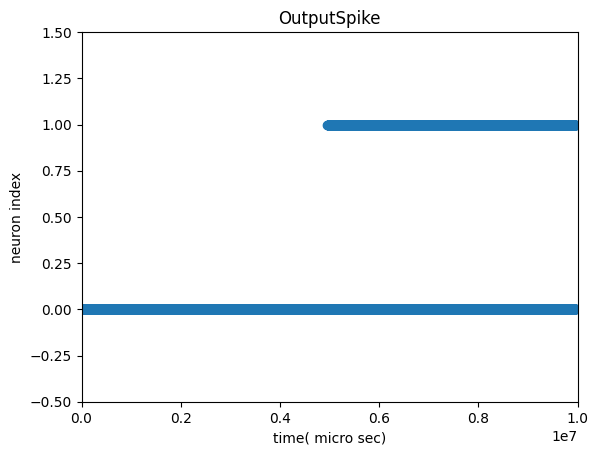

In [13]:
print(f"number of fake input spikes: {len(input_events)}")
print(f"number of output spikes from DynacpCNN Layer: {len(dynapcnn_layer_events)}")

# get the timestamp of the output event
spike_timestamp = [each.timestamp for each in dynapcnn_layer_events]
# shift timestep starting from 0
start_t = spike_timestamp[0]
spike_timestamp = [each - start_t for each in spike_timestamp]

# get the neuron index of each output spike
neuron_id = [each.feature for each in dynapcnn_layer_events]

# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(spike_timestamp, neuron_id)
ax.set(xlim=(0, input_time_length * 1e6), ylim=(-0.5, 1.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("OutputSpike")

In [14]:
samna_graph.stop()
samna.device.close_device(devkit)